In [3]:
import numpy as np
import pylab as plt
import scipy.stats as ss
from collections import Counter
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../..')))
from pyabc.examples import tuberculosis
import pyabc.prior
from pyabc.plots import plot_marginals, plot_particles, plot_pairs
%matplotlib notebook

## Intractable model by Tanaka et al. 2006 for spread of tuberculosis

![](img/transmission_process.png)

### model parameter
$\alpha$: rate with which each infectious host randomly infects other individuals from an unlimited supply of hosts

$\delta$: rate with which a host stops being infectious, either by recovering or dying

$\tau$: rate with which the pathogen of the host mutates randomly within the host, generating a novel haplotype under a single-locus infinite alleles model

$\theta = (\alpha, \delta, \tau)$

$y_{\theta} = (6,3,2,2,1,1,1,1,1,1,1)$: output, vector of clusters, that is different haplotypes. Each number represents the infectious hosts for this particular haplotype

### Observation
$\alpha = 0.2, \delta = 0, \tau = 0.198, m = 20$

assume, that $\delta, \tau$ are known and apply uniform prior

In [4]:
alpha = 0.2
delta = 0.0
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.005, 2, name=r"$\alpha$")
#prior_tau = pyabc.Prior("uniform", 0.01, 1, name="$\tau$")

list_of_priors = [prior_alpha]

simulator = tuberculosis.simulator

In [5]:
# for i in range(100):
#     params = [prior_alpha.sample(),prior_delta.sample(),prior_tau.sample()]
#     y0 = simulator(*params)

params = [alpha, tau, delta]



y0 = np.array([6,3,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # from paper

summaries = [lambda x: x]

# BOLFI

In [6]:
bolfi = pyabc.BOLFI(priors=list_of_priors, simulator=simulator, 
                             summaries=summaries,
                             observation=y0, domain=[(0.005, 2.005)])



In [5]:
bolfi.fit(initial_evidence_size=10, max_iter=200)

Starting Bayesian Optimization with initial evidence size = 10, max_iter = 200
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [ ]:
bolfi.optim.plot_acquisition()

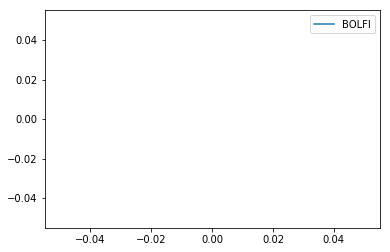

In [80]:
x = np.linspace(0,2)[:,np.newaxis]
bolfi_post = bolfi.extract_posterior(threshold=0.0025)
plt.plot(x, bolfi_post(x) / np.sum(bolfi_post(x)), label='BOLFI')
plt.legend()

In [15]:
bolfi.sample(nr_samples=10_000, threshold=0, n_chains=4, burn_in=100)

Approximating likelihood with threshold 0
Obtaining 10000 MCMC sampling using approximate likelihood with 4 chains and 100 burn-in samples
Samples:  10004 - Acceptance rate: 0.000000


array([[1.73894869],
       [1.73894869],
       [1.73894869],
       ...,
       [1.645992  ],
       [1.645992  ],
       [1.645992  ]])

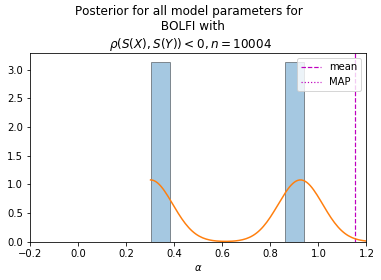

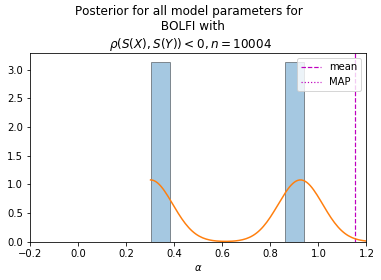

In [16]:
plot_marginals(bolfi, xlim=[[-0.2, 1.2]])

# BOLFI using ELFI

In [7]:
import elfi

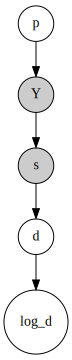

In [8]:
elfi.new_model()

p = elfi.Prior('uniform', 0.005, 2)

def sim(x, batch_size, random_state):
    return simulator(x[0])

Y = elfi.Simulator(sim, p, observed=y0)

s = elfi.Summary(lambda x: x[np.newaxis,:], Y)

d = elfi.Distance('euclidean', s)

log_d = elfi.Operation(np.log, d)

elfi.draw(d)

In [42]:
elfibolfi = elfi.BOLFI(d, batch_size=1, initial_evidence=10, update_interval=10,
                   bounds={'p': (0.005, 2.005)}, acq_noise_var=[0.1], seed=101)

In [43]:
post = elfibolfi.fit(n_evidence=1000, threshold=0.02)

In [45]:
result_elfi = elfibolfi.sample(10000, info_freq=1000)

4 chains of 10000 iterations acquired. Effective sample size and Rhat for each parameter:
p 4073.2374383534475 1.0011575352178876


In [46]:
thetas = result_elfi.samples['p']

In [47]:
xx = np.linspace(np.min(thetas), np.max(thetas), 400)

In [55]:
# read reference (rejection ABC) posterior
rej = pyabc.RejectionSampler.load('/home/dominik/Dropbox/Studium/AppliedCognitiveModelling2017/ABC/03 data/ex02/rej_10000_0.pkl')
rej.Thetas

rej_thetas = rej.Thetas[:,0]
rej_kde = ss.kde.gaussian_kde(rej_thetas)
rej_dens = rej_kde(xx)

In [49]:
# read reference (rejection ABC) posterior
mcmc = pyabc.MCMCSampler.load('/home/dominik/Dropbox/Studium/AppliedCognitiveModelling2017/ABC/03 data/ex02/mcmc_10000_0_0_1.pkl')
mcmc.Thetas

mcmc_thetas = mcmc.Thetas[:,0]
mcmc_kde = ss.kde.gaussian_kde(mcmc_thetas)
mcmc_dens = mcmc_kde(xx)

<IPython.core.display.Javascript object>


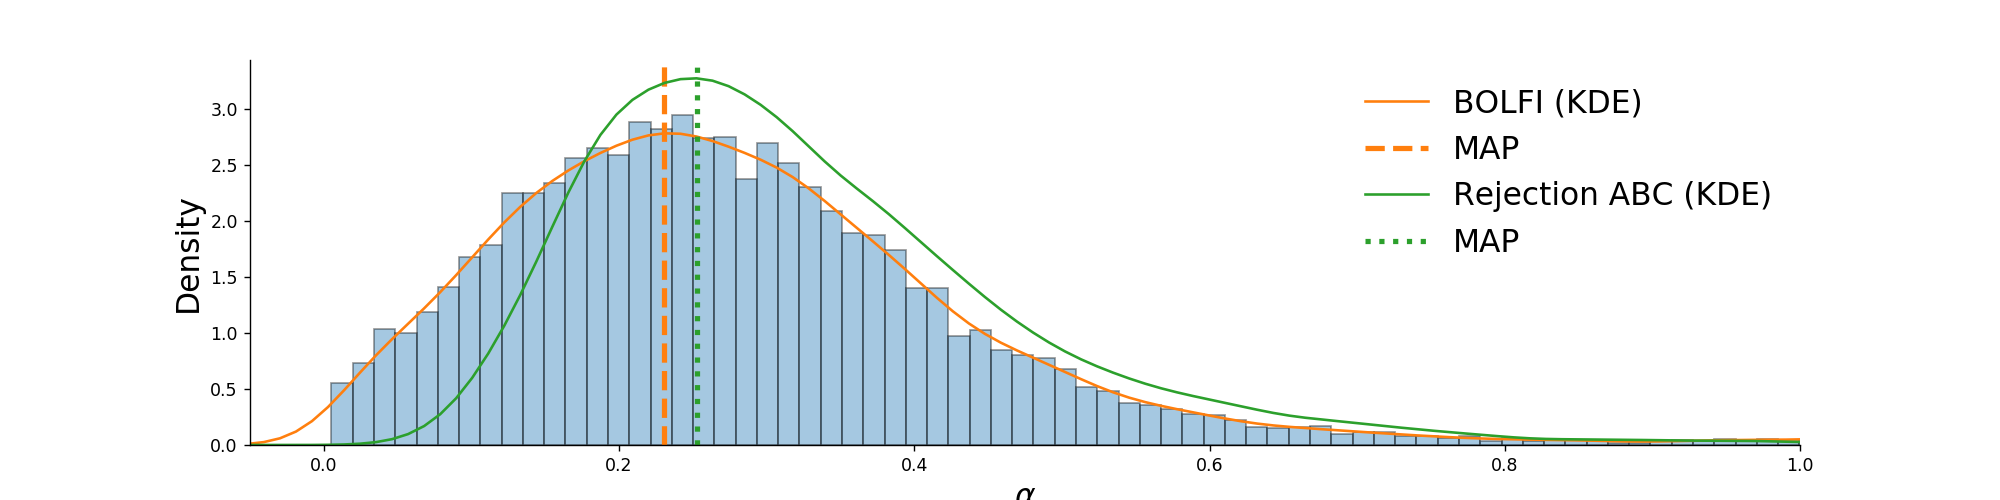

In [56]:
axes = result_elfi.plot_marginals(normed=True, bins='auto', edgecolor='k', alpha=0.4)
axes[0].set_xlim((-0.05, 1.0))
axes[0].set_xlabel(r'$\alpha$', fontsize=18)
axes[0].set_ylabel('Density', fontsize=18)


kde = ss.kde.gaussian_kde(thetas)
dens = kde(xx)
axes[0].plot(xx, dens, label="BOLFI (KDE)")
#axes[0].axvline(np.mean(thetas), linewidth=3.0, linestyle="--", color='C1', label="mean")
axes[0].axvline(xx[np.argmax(dens)], linewidth=3.0, linestyle="--", color='C1', label="MAP")

axes[0].plot(xx, rej_dens, label="Rejection ABC (KDE)", color='C2')
#axes[0].axvline(np.mean(rej_thetas), linewidth=3.0, linestyle="--", color='C2', label="mean")
axes[0].axvline(xx[np.argmax(rej_dens)], linewidth=3.0, linestyle=":", color='C2', label="MAP")

axes[0].spines["top"].set_visible(False)  
axes[0].spines["right"].set_visible(False) 
plt.legend(frameon=False, fontsize=18)

plt.savefig('bolfi_tuberculosis.pdf')

In [57]:
import scipy.special as spec
reference = rej_kde


xx = np.linspace(np.min(thetas) - 0.1, np.max(thetas) + 0.1, 200)


    
kde = ss.kde.gaussian_kde(thetas)

p = kde(xx)
q = reference(xx)

def kl(p, q):

    # plot posterior
    #plt.hist(theta, normed=True, alpha=0.2, color=tableau20[i*2], bins="auto")
    # plot KDE and MAP
    # get the bandwidth method argument for scipy
    # and run scipy's kde
    
    kl = ss.entropy(
                        np.where(p < 1e-20, 1e-20, p),
                        np.where(q < 1e-20, 1e-20, q))
                
    return kl

print(kl(p, q))
#print(ss.entropy(p,q))

0.23152207223868454


In [75]:
post = elfibolfi.extract_posterior(0)

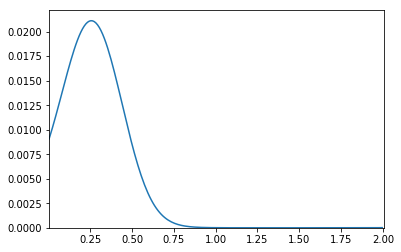

In [76]:
post.plot()

## Step by step Bayesian Optimization

In [15]:
from bayes_opt import BayesianOptimization


In [16]:
f = lambda thetas: np.log(self.distance(stats_x,
                                flatten_function(self.summaries, self.simulate(thetas.flatten()))))

def nl_dist(x):
    return -np.log(np.linalg.norm(y0 - simulator(x)))

nl_dist(1.1)

-1.7328679513998633

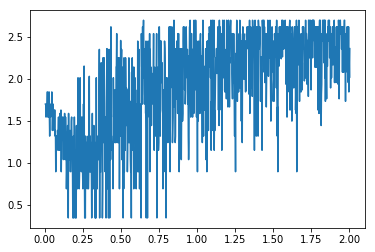

In [17]:
x = np.linspace(0.005,2.005, 1000).reshape(-1, 1)
y = np.array([-nl_dist(xi[0]) for xi in x]).reshape(-1, 1)
plt.plot(x, y)

In [18]:
from matplotlib import gridspec
import matplotlib

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, gs=None, xlim=None, ylim=None, legend=True, ylabel=True, xlabel=True):
    
    if not gs:
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
        
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    #axis.plot(x, y, linewidth=3, label='Distance')
    axis.plot(bo.X.flatten(), np.exp(-bo.Y), 'D', markersize=8, label=u'Evidence set', color='m')
    axis.plot(x, np.exp(-mu), '--', color='k', label='Distance (GP mean)')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([np.exp(-mu - 1.000 * sigma), np.exp(-mu + 1.000 * sigma)[::-1]]),
        alpha=.4, fc='C0', ec='None', label='Standard deviation')
    
    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    
    axis.get_xaxis().set_ticklabels([])
    
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, -utility, label='Acquisition Function', color='C1')
    acq.plot(x[np.argmax(utility)], -np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='m', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim(xlim)
    #acq.set_ylim((0, np.max(utility) + 0.5))
    
    if ylabel:
        axis.set_ylabel(r'$J(\theta)$', fontdict={'size':20})
        acq.set_ylabel(r'$\mathcal{A}(\theta)$', fontdict={'size':20})
    else:
        acq.get_yaxis().set_ticklabels([])
        axis.get_yaxis().set_ticklabels([])
        
    if xlabel:
        #axis.set_xlabel(r'$\theta$', fontdict={'size':20})
        acq.set_xlabel(r'$\theta$', fontdict={'size':20})
    else:
        acq.get_xaxis().set_ticklabels([])
        
    axis.spines["top"].set_visible(False)  
    axis.spines["right"].set_visible(False)  
    acq.spines["top"].set_visible(False)  
    acq.spines["right"].set_visible(False)  
  
    
    
    
    if legend:
        axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
        acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
        
    return axis, acq

In [19]:
# fig = plt.figure(figsize=(10, 10))
# fig.suptitle('Gaussian Process and Acquisition Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |   -1.03972 |    0.3644 | 
    2 | 00m00s |   -2.35024 |    1.8868 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m00s |   -1.84444 |    0.0050 | 
    4 | 00m00s |   -1.95601 |    0.9760 | 


(<matplotlib.axes._subplots.AxesSubplot at 0x7f07280a20f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f071a39b438>)

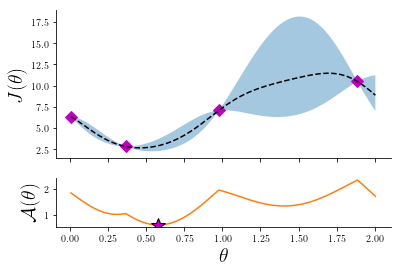

In [42]:
import matplotlib.gridspec as gridspec

bo = BayesianOptimization(nl_dist, {'x': (0.005, 2.005)})
bo.maximize(init_points=2, n_iter=2, acq='ucb', kappa=2.0)

plot_gp(bo, x, legend=False)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    5 | 00m00s |   -1.66610 |    1.4284 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    6 | 00m01s |   -0.89588 |    0.6262 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    7 | 00m00s |   -0.69315 |    0.5035 | 


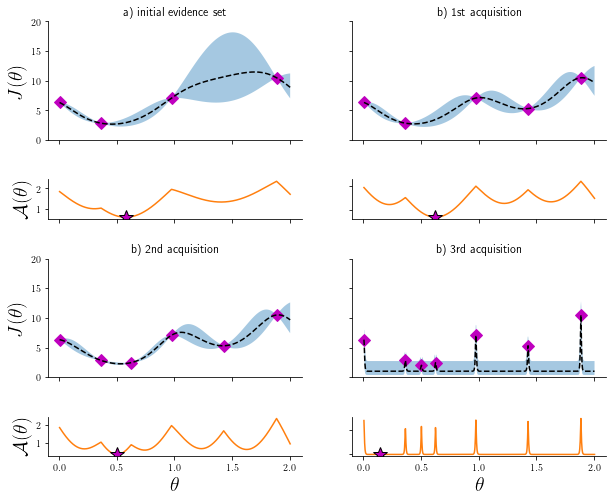

In [43]:
ylim = (0, 20)


f = plt.figure(figsize=(10, 8))
outer_grid = gridspec.GridSpec(2, 2, hspace=0.2, wspace=0.2)

gs = [gridspec.GridSpecFromSubplotSpec(2, 1, 
                                       subplot_spec=outer_grid[i], hspace=0.5, 
                                       height_ratios=[3,1]) for i in range(4)]

titles = ['a) initial evidence set', 'b) 1st acquisition', 'b) 2nd acquisition', 'b) 3rd acquisition']
for i, title in zip(range(4), titles):
    if i in [1,3]:
        ylabel=False
    else:
        ylabel=True
    if i in [0,1]:
        xlabel=False
    else:
        xlabel=True
    axis, acq = plot_gp(bo, x, gs[i], ylim=ylim, legend=False, ylabel=ylabel, xlabel=xlabel)
    
    axis.set_title(title)
    
    if i < 3:
        bo.maximize(init_points=0, n_iter=1, kappa=5.0)


##f.legend((l1, l2), ('Line 1', 'Line 2'), 'upper left')
##f.legend((l3, l4), ('Line 3', 'Line 4'), 'upper right')
f.savefig('gp.pdf')

In [108]:
import scipy.stats as ss

def loglikelihood(theta, threshold):
    # eqn 47 from BOLFI paper
    m, s = bo.gp.predict(theta, return_std=True)
    # F = gaussian cdf, see eqn 28 in BOLFI paper
    return ss.norm.logcdf((np.log(threshold) + m) / s).flatten()

# compute posterior from likelihood and prior
# includes check for bounds
# TODO: check if log works correctly, when likelihood or prior == 1 -> log = 0
def logposterior(theta, threshold):
    return loglikelihood(theta, threshold)[:,np.newaxis] + prior_alpha.logpdf(theta)

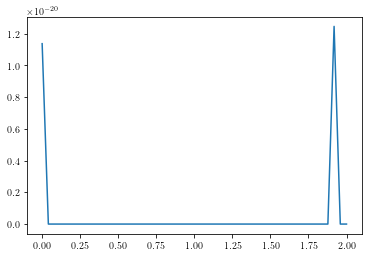

In [51]:
x = np.linspace(0,2)[:,np.newaxis]
plt.figure()
plt.plot(x, np.exp(loglikelihood(x, 0.0025)))


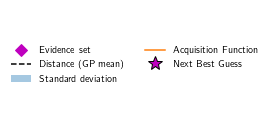

In [168]:
axis_handles, axis_labels = axis.get_legend_handles_labels()
acq_handles, acq_labels = acq.get_legend_handles_labels()

handles, labels = axis_handles+acq_handles, axis_labels+acq_labels

fig_legend = plt.figure(figsize=(2,2))
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, labels, loc='center', scatterpoints = 1, frameon=False, ncol=2)
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
plt.axis('off')
fig_legend.canvas.draw()
fig_legend.show()
plt.savefig('legend1.pdf', bbox_inches='tight')

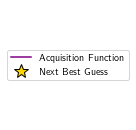

In [355]:
handles,labels = axes[1].get_legend_handles_labels()

fig_legend = plt.figure(figsize=(2,2))
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, labels, loc='center', scatterpoints = 1)
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
plt.axis('off')
fig_legend.canvas.draw()
fig_legend.show()
plt.savefig('legend2.pdf')